# 10 minutes to Dask

https://docs.dask.org/en/stable/10-minutes-to-dask.html

## DataFrame

### Creating an object

In [33]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [34]:
index = pd.date_range("2021-09-01", periods=2400, freq="1H")
df = pd.DataFrame({
    "a": np.arange(2400),
    "b": list("abcaddbe" * 300)
    },
    index=index)
print("# Pandas df")
display(df)

print("# Dask df")
ddf = dd.from_pandas(df, npartitions=10)
display(ddf)

# Pandas df


,a,b
2021-09-01 00:00:00,0,a
2021-09-01 01:00:00,1,b
2021-09-01 02:00:00,2,c
2021-09-01 03:00:00,3,a
2021-09-01 04:00:00,4,d
...,...,...
2021-12-09 19:00:00,2395,a
2021-12-09 20:00:00,2396,d
2021-12-09 21:00:00,2397,d
2021-12-09 22:00:00,2398,b


# Dask df


,a,b
npartitions=10,,
2021-09-01 00:00:00,int64,object
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [35]:
ddf.divisions

(Timestamp('2021-09-01 00:00:00', freq='H'),
 Timestamp('2021-09-11 00:00:00', freq='H'),
 Timestamp('2021-09-21 00:00:00', freq='H'),
 Timestamp('2021-10-01 00:00:00', freq='H'),
 Timestamp('2021-10-11 00:00:00', freq='H'),
 Timestamp('2021-10-21 00:00:00', freq='H'),
 Timestamp('2021-10-31 00:00:00', freq='H'),
 Timestamp('2021-11-10 00:00:00', freq='H'),
 Timestamp('2021-11-20 00:00:00', freq='H'),
 Timestamp('2021-11-30 00:00:00', freq='H'),
 Timestamp('2021-12-09 23:00:00', freq='H'))

In [36]:
ddf.partitions[1]

,a,b
npartitions=1,,
2021-09-11,int64,object
2021-09-21,...,...


### Indexing

In [37]:
ddf["b"]

Dask Series Structure:
npartitions=10
2021-09-01 00:00:00    object
2021-09-11 00:00:00       ...
                        ...  
2021-11-30 00:00:00       ...
2021-12-09 23:00:00       ...
Name: b, dtype: object
Dask Name: getitem, 2 graph layers

In [38]:
# This doesn't force to read.
ddf["2021-10-01": "2021-10-09 5:00"]

,a,b
npartitions=1,,
2021-10-01 00:00:00.000000000,int64,object
2021-10-09 05:00:59.999999999,...,...


### Computation

In [39]:
# Force to read.
ddf["2021-10-01": "2021-10-09 5:00"].compute()

,a,b
2021-10-01 00:00:00,720,a
2021-10-01 01:00:00,721,b
2021-10-01 02:00:00,722,c
2021-10-01 03:00:00,723,a
2021-10-01 04:00:00,724,d
...,...,...
2021-10-09 01:00:00,913,b
2021-10-09 02:00:00,914,c
2021-10-09 03:00:00,915,a
2021-10-09 04:00:00,916,d


### Methods

In [40]:
ddf.a.mean()

dd.Scalar<series-..., dtype=float64>

In [41]:
# Note that the types are different.
display(ddf["b"].unique().compute())

display(ddf["b"].compute().unique())

0    a
1    b
2    c
3    d
4    e
Name: b, dtype: object

array(['a', 'b', 'c', 'd', 'e'], dtype=object)

In [42]:
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100
result

Dask Series Structure:
npartitions=1
2021-10-01 00:00:00.000000000    int64
2021-10-09 05:00:59.999999999      ...
Name: a, dtype: int64
Dask Name: sub, 7 graph layers

In [43]:
result.compute()

2021-10-01 00:00:00       620
2021-10-01 01:00:00      1341
2021-10-01 02:00:00      2063
2021-10-01 03:00:00      2786
2021-10-01 04:00:00      3510
                        ...  
2021-10-09 01:00:00    158301
2021-10-09 02:00:00    159215
2021-10-09 03:00:00    160130
2021-10-09 04:00:00    161046
2021-10-09 05:00:00    161963
Freq: H, Name: a, Length: 198, dtype: int64

### Visualize the Task Graph

In [44]:
result.dask

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f4cf92ed3c0>
 0. from_pandas-e8d0c92b0364d788dd904838361b0fa2
 1. loc-4d57ed2634286c47ae7720535278fbac
 2. getitem-4abd5e5ddddab80f6cd715ad4c862e3b
 3. series-cumsum-map-ec0a737e92fd3d3fdb31508b4efb8997
 4. series-cumsum-take-last-3d314821fd8abbba14916b16e8e0648b
 5. series-cumsum-560074f709f422817cc9f94ccb8dd221
 6. sub-11050f195b967cdf56e9c4518c59eecf

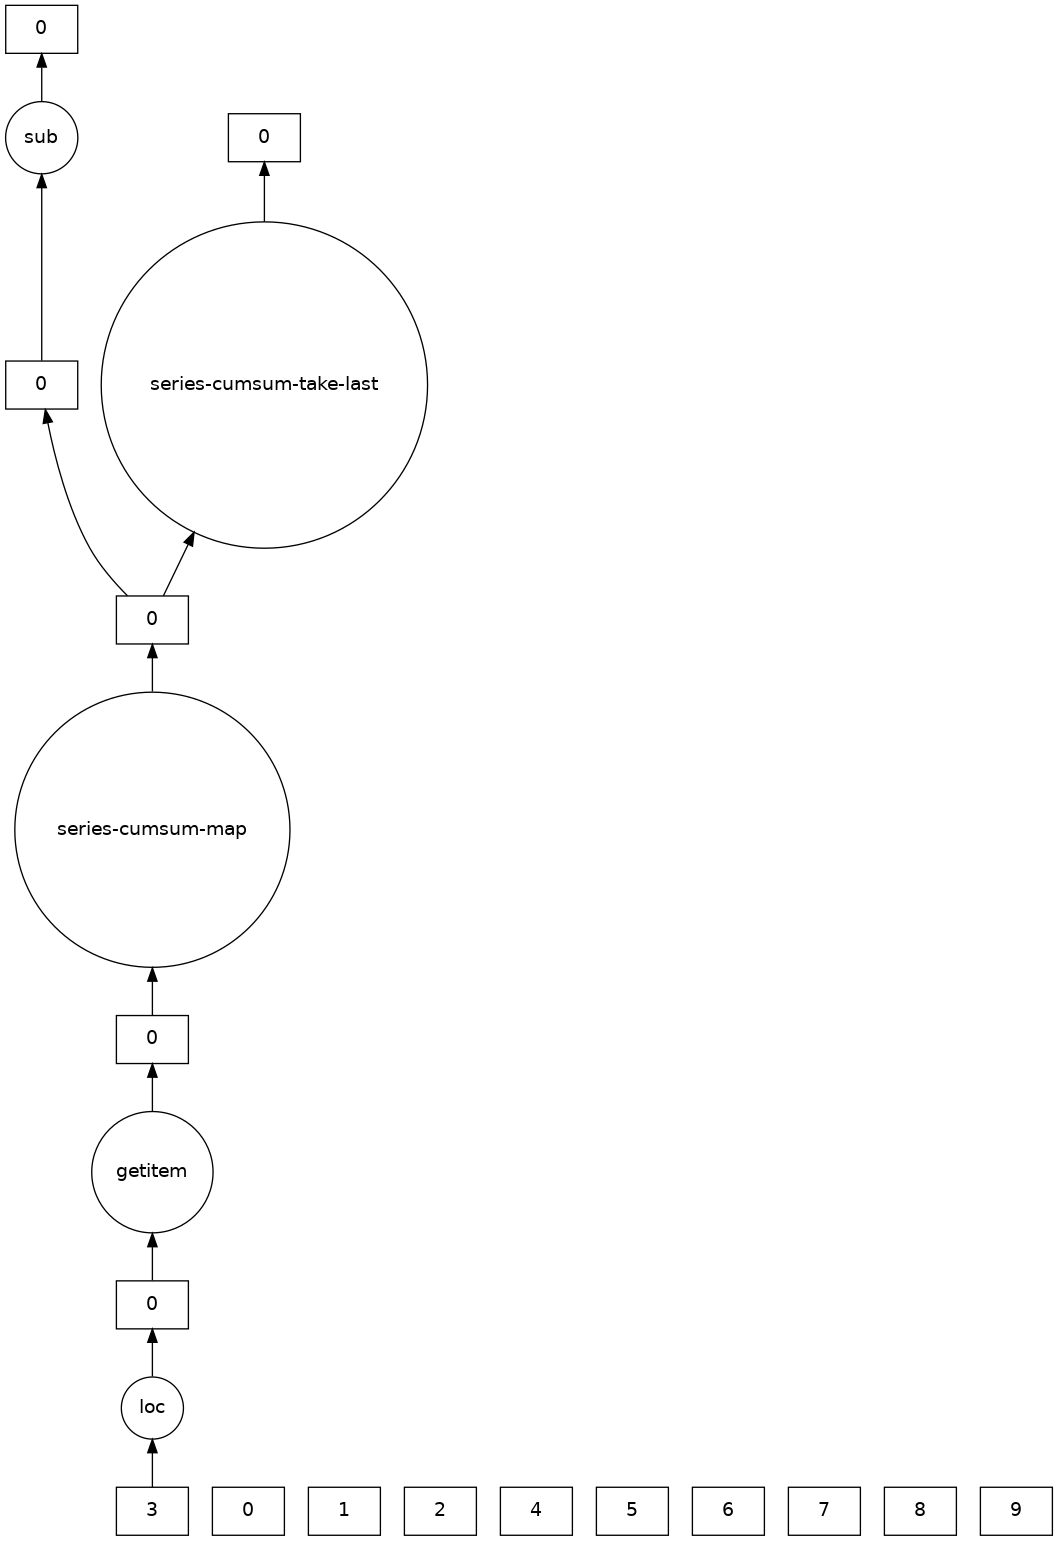

In [45]:
result.visualize()

## Array

### Creating an object

In [55]:
import numpy as np
import dask.array as da

# Create a 200 x 500 array.
data = np.arange(100_000).reshape(200, 500)
print(data.shape)
print("data=\n%s" % data)

(200, 500)
data=
[[    0     1     2 ...   497   498   499]
 [  500   501   502 ...   997   998   999]
 [ 1000  1001  1002 ...  1497  1498  1499]
 ...
 [98500 98501 98502 ... 98997 98998 98999]
 [99000 99001 99002 ... 99497 99498 99499]
 [99500 99501 99502 ... 99997 99998 99999]]


In [56]:
# Split in 100x100 chunks.
a = da.from_array(data, chunks=(99, 99))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(99, 99), chunktype=numpy.ndarray>

In [57]:
# Split in 100x100 chunks.
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [58]:
a.chunks

((100, 100), (100, 100, 100, 100, 100))

In [59]:
a.blocks[1, 3]

dask.array<blocks, shape=(100, 100), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

### Indexing

In [60]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>

### Computation

In [61]:
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

### Methods

In [62]:
a.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [63]:
a.mean().compute()

49999.5

In [64]:
np.sin(a)

dask.array<sin, shape=(200, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [65]:
a.T

dask.array<transpose, shape=(500, 200), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [67]:
b = a.max(axis=1)[::-1] + 10
b

dask.array<add, shape=(200,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

### Visualize the Task Graph

In [68]:
b.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f4cf86b7370>
 0. array-5f1b3c0ca172b03296ed6d431d3c9df7
 1. chunk_max-22359f6e7c214a78df6cd2673d3d603f
 2. chunk_max-partial-1dbed0d768d7fbafb3cb682ddb58870a
 3. amax-aggregate-f94050a9bd8876b51c0d09825ac793c8
 4. getitem-025f8710b7fd9db8a9d07629455d3e1a
 5. add-edf7897f1db3089799c2ef91c0c476db

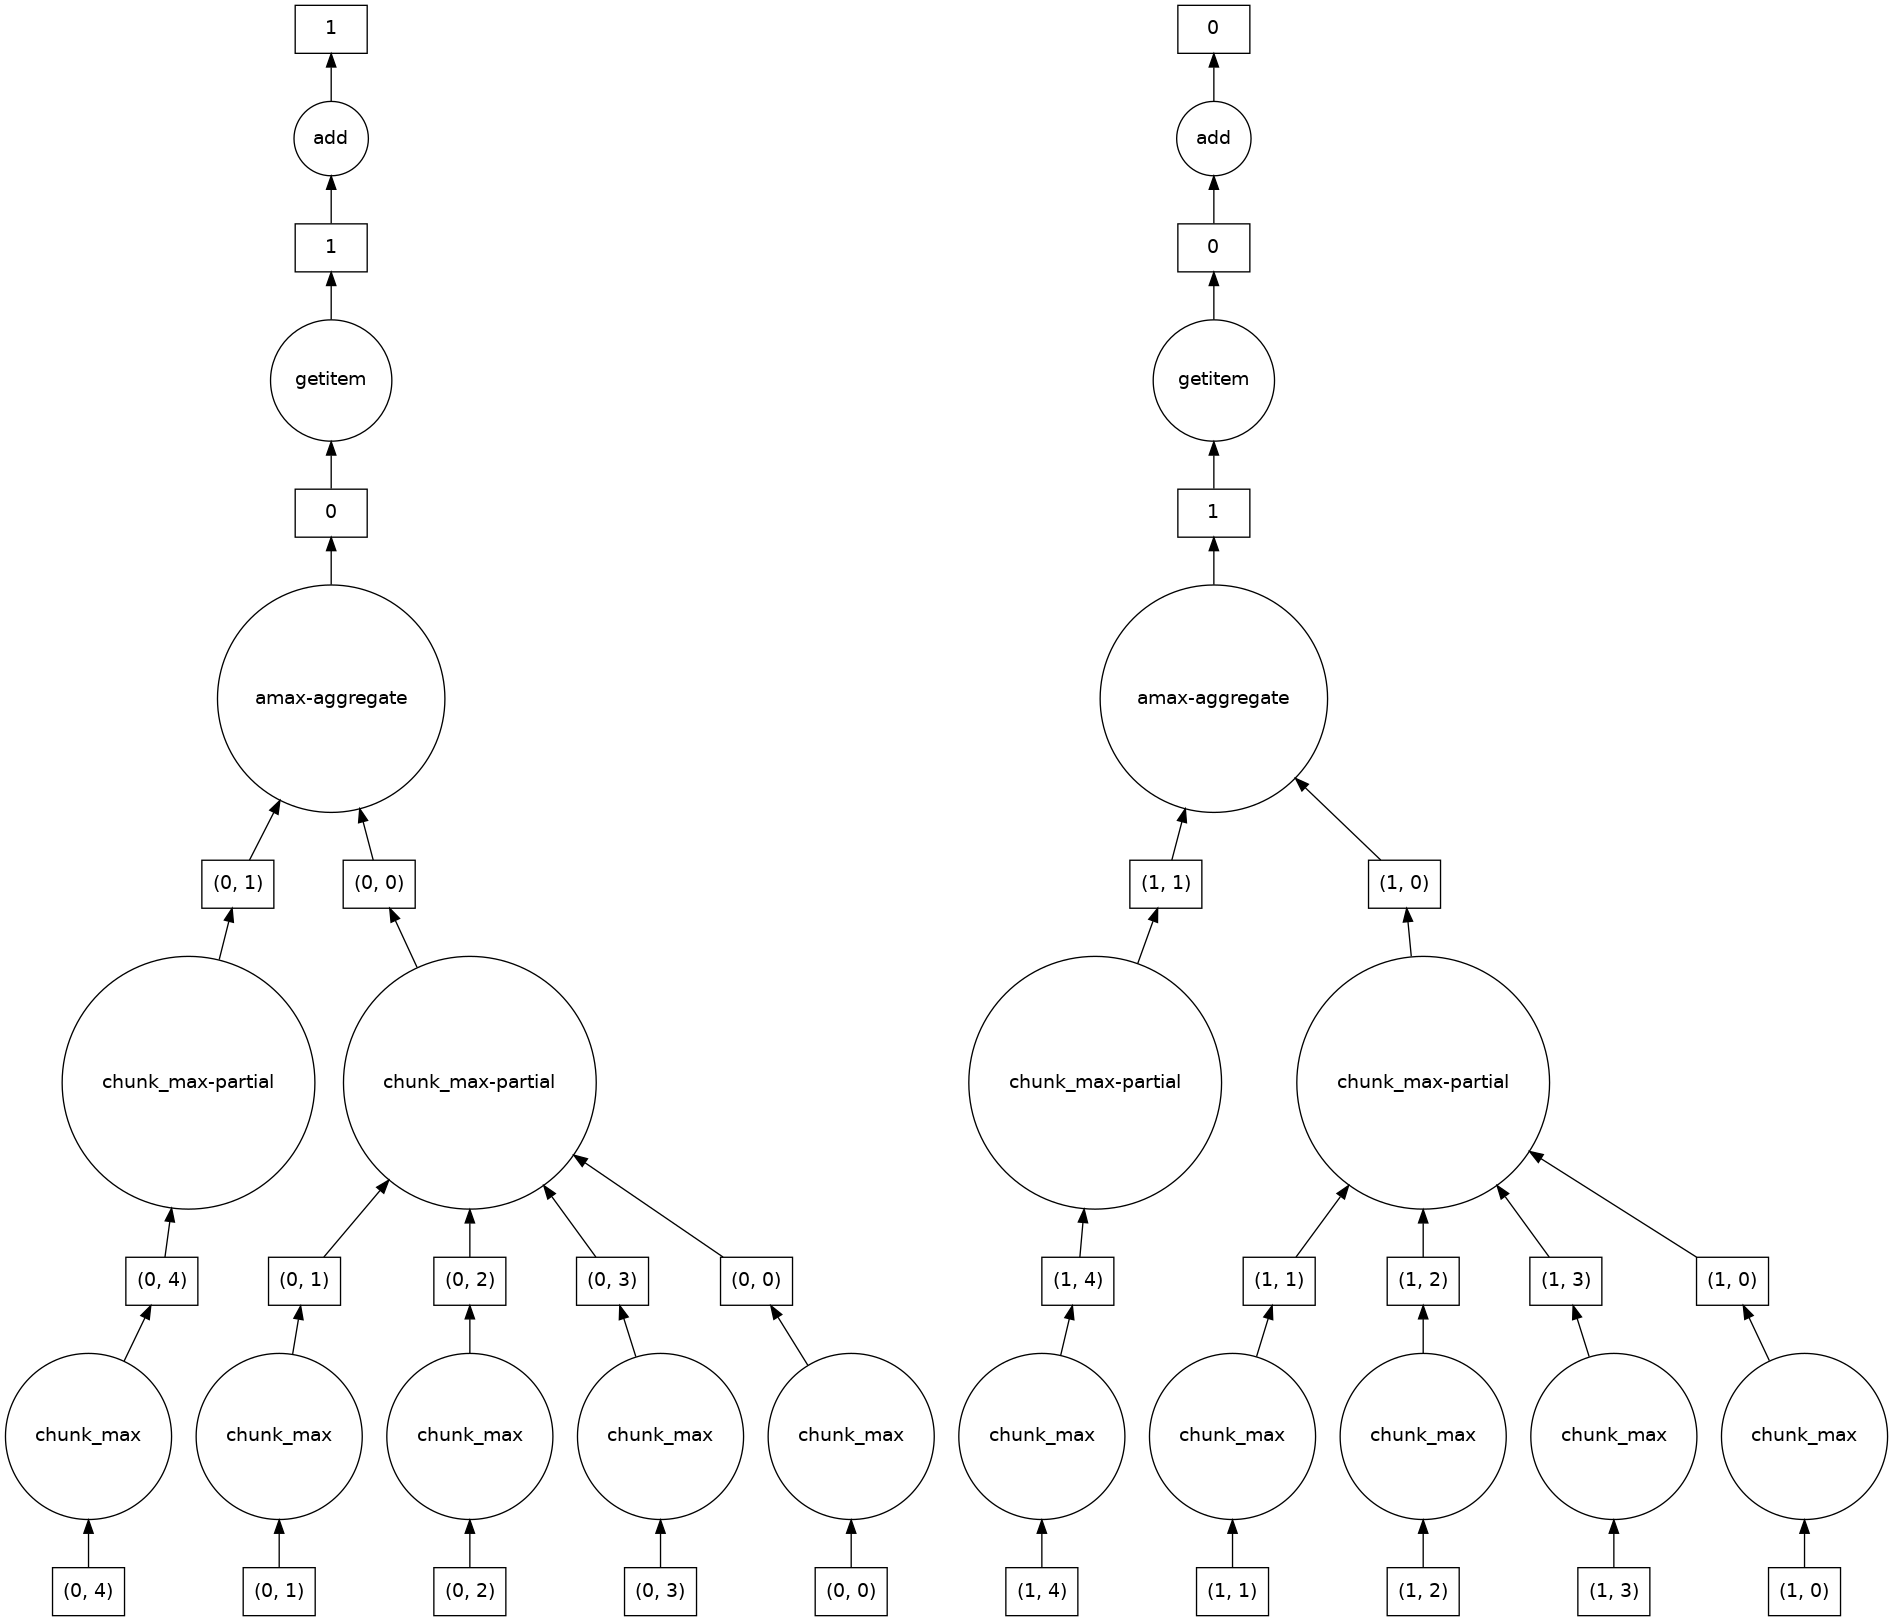

In [69]:
b.visualize()

## Bag 

### Creating a Dask object

In [70]:
# 8 items in two partitions.
b = db.from_sequence([1, 2, 3, 4, 5, 6, 2, 1], npartitions=2)

b

dask.bag<from_sequence, npartitions=2>

### Indexing

### Computation

In [71]:
b.compute()

[1, 2, 3, 4, 5, 6, 2, 1]

### Methods

In [72]:
b.filter(lambda x: x % 2)

dask.bag<filter-lambda, npartitions=2>

In [73]:
b.filter(lambda x: x % 2).compute()

[1, 3, 5, 1]

In [74]:
b.distinct()

dask.bag<distinct-aggregate, npartitions=1>

In [75]:
b.distinct().compute()

[1, 2, 3, 4, 5, 6]

In [76]:
c = db.zip(b, b.map(lambda x: x * 10))
c.compute()

[(1, 10), (2, 20), (3, 30), (4, 40), (5, 50), (6, 60), (2, 20), (1, 10)]

### Visualize the Task Graph